In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import fsolve


Approximate run duration: 48 hours

In [ ]:
def h_tf(a, b, d, x):
    return (a*x-b)/(1.0000 -np.exp(-d*(a*x-b)))
def dh_tf(a,b,d, x):

        tmp_e=np.exp(-d*(a*x-b))
        tmp_d=1.-np.exp(-d*(a*x-b))
        slope_E=(a*tmp_d-(a*x-b)*d*a*tmp_e)/tmp_d**2
        return slope_E

def smooth_normalize(x):
    if x < 0.000001:
        x =0.000001
    return x

##### Wong-wang deco + Balloon BOLD
def derivative_orig(x): ### var is a vectior with 6 which is arragned by: E, I from Neural Model 
                                                                           ###    q, v, f, x from Balloon Model
    

    # Equations for the neural masses
    E = x.reshape((2,50))[0]
    I = x.reshape((2,50))[1]
    

    W_E = param["W_E"]
    tau_E = param["tau_E"]
    gamma_E = param["gamma_E"]

    W_I = param["W_I"]
    tau_I = param["tau_I"]
    gamma_I = param["gamma_I"]

    I_0 = param["I_0"]
    
    g_EE = param["g_EE"]
    g_IE = param["g_IE"]
    g_EI = param["g_EI"]
    aE = param["aE"]
    bE = param["bE"] 
    dE = param["dE"]
    aI = param["aI"]
    bI = param["bI"] 
    dI = param["dI"]

    IE = W_E*I_0 +g_EE*E -g_IE*I  #  input currents for E
    II = W_I*I_0 +g_EI*E -I  #  input currents for I 
    rE = h_tf(aE, bE, dE, IE) # firing rate for E
    rI = h_tf(aI, bI, dI, II) # firing rate for I 
    ddE = -E/tau_E +gamma_E*(1.-E)*rE  ### equlibrim point at E=(tau_E*gamma_E*rE)/(1+tau_E*gamma_E*rE)
    ddI = -I/tau_I +gamma_I*rI         ### equlibrim point at I=tau_I*gamma_I*rI


    #print(rE, rI)

    return np.array([ddE, ddI]).ravel()

##### Wong-wang deco + Balloon BOLD
def derivative(x): ### var is a vectior with 6 which is arragned by: E, I from Neural Model 
                                                                           ###    q, v, f, x from Balloon Model
    

    # Equations for the neural masses
    E = x[0]
    I = x[1]
    

    W_E = param["W_E"]
    tau_E = param["tau_E"]
    gamma_E = param["gamma_E"]

    W_I = param["W_I"]
    tau_I = param["tau_I"]
    gamma_I = param["gamma_I"]

    I_0 = param["I_0"]
    
    g_EE = param["g_EE"]
    g_IE = param["g_IE"]
    g_EI = param["g_EI"]
    aE = param["aE"]
    bE = param["bE"] 
    dE = param["dE"]
    aI = param["aI"]
    bI = param["bI"] 
    dI = param["dI"]

    IE = W_E*I_0 +g_EE*E -g_IE*I  #  input currents for E
    II = W_I*I_0 +g_EI*E -I  #  input currents for I 
    rE = h_tf(aE, bE, dE, IE) # firing rate for E
    rI = h_tf(aI, bI, dI, II) # firing rate for I 
    ddE = -E/tau_E +gamma_E*(1.-E)*rE  ### equlibrim point at E=(tau_E*gamma_E*rE)/(1+tau_E*gamma_E*rE)
    ddI = -I/tau_I +gamma_I*rI         ### equlibrim point at I=tau_I*gamma_I*rI


    #print(rE, rI)

    return 10000.0*np.array([ddE, ddI])

In [ ]:
### linearize the system and calculate the eigenvalues
def get_eig_sys(E, I, param):
    
    def h_tf(a, b, d, x):
        return (a*x-b)/(1.0000 -np.exp(-d*(a*x-b)))
        
    def dh_tf(a,b,d, x):

        tmp_e=np.exp(-d*(a*x-b))
        tmp_d=1.-np.exp(-d*(a*x-b))
        slope_E=(a*tmp_d-(a*x-b)*d*a*tmp_e)/tmp_d**2
        return slope_E
    
    W_E = param["W_E"]
    tau_E = param["tau_E"]
    gamma_E = param["gamma_E"]

    W_I = param["W_I"]
    tau_I = param["tau_I"]
    gamma_I = param["gamma_I"]

    I_0 = param["I_0"]
    
    g_EE = param["g_EE"]
    g_IE = param["g_IE"]
    g_EI = param["g_EI"]
    aE = param["aE"]
    bE = param["bE"] 
    dE = param["dE"]
    aI = param["aI"]
    bI = param["bI"] 
    dI = param["dI"]

    IE = W_E*I_0 +g_EE*E -g_IE*I  #  input currents for E
    II = W_I*I_0 +g_EI*E -I  #  input currents for I 
    rE = h_tf(aE, bE, dE, IE) # firing rate for E
    rI = h_tf(aI, bI, dI, II)
    drEdIE = dh_tf(aE, bE, dE, IE)
    drIIdII = dh_tf(aI, bI, dI, II)
    
    A = np.zeros((2,2))
    A[0,0] = -1/tau_E - gamma_E*h_tf(aE, bE, dE, IE) +(1- E)*gamma_E* drEdIE *g_EE
    A[0,1] = -(1-E)*gamma_E* drEdIE *g_IE
    A[1,0] = gamma_I*drIIdII*g_EI
    A[1, 1] = - gamma_I*drIIdII
    A =np.nan_to_num(A)
    
    
    d, U = np.linalg.eig(A)
    return d
    

In [ ]:
param = {

# Parameters for the integration
"dt"         : 0.001,     # integration step size   
"ROI_num" : 1,       # number of neural nodes


# Parameters for the ODEs
# Excitatory population
"W_E" : 1.,              # scale of the external input
"tau_E" : 100.,          # decay time
"gamma_E" : 0.641/1000.,       # other dynamic parameter (?)

# Inhibitory population
"W_I" : 0.7,             # scale of the external input
"tau_I" : 10.,           # decay time
"gamma_I" : 1./1000.,          # other dynamic parameter (?)

# External input
"I_0" : 0.45,          # external input
"I_external" : 0.,       # external stimulation

# Coupling parameters
"g" : 20.,               # global coupling (from all nodes E_j to single node E_i)
"g_EE" : .5,            # local self excitatory feedback (from E_i to E_i)
"g_IE" : .14,            # local inhibitory coupling (from I_i to E_i)
"g_EI" : 0.15,            # local excitatory coupling (from E_i to I_i)
"lamb" : 0.,             # scale of global coupling on I_i (compared to E_i)

"aE":310,
"bE" :125,
"dE":0.16,
"aI":615,
"bI" :177, 
"dI" :0.087, 



} ### initial values of all model prameters

In [ ]:
#### 

def regime_search_I0(I0_rng, gEE_rng, gIE_rng, gEI_rng):
    
    param_study = ['g_EE', 'g_IE', 'g_EI', 'I_0']
    num_param = 3
    num_trials = 15

  

    gEE, gIE, gEI = np.meshgrid(gEE_rng, gIE_rng, gEI_rng)
   
    gEE_good =[]
    gIE_good =[]
    gEI_good =[]
    
    c_I0=[]

    for I0 in I0_rng:
        print(I0)
        param['I_0'] = I0
        c=[]

        for i in range(num_trials**num_param):
            ind_0 = i//num_trials**(num_param -1)
            ind_1 = (i%num_trials**(num_param -1)) //num_trials**(num_param -2)
            ind_2 = ((i%num_trials**(num_param -1)) % num_trials**(num_param -2)) // num_trials**(num_param -3)
            #ind_3 = ((i%num_trials**(num_param -1)) % num_trials**(num_param -2)) % num_trials**(num_param -3)
            param['g_EE'] = gEE[ind_0][ind_1][ind_2]#[ind_3]
            param['g_IE'] = gIE[ind_0][ind_1][ind_2]#[ind_3]
            param['g_EI'] = gEI[ind_0][ind_1][ind_2]#[ind_3]
            #param['I_0'] = I0[ind_0][ind_1][ind_2][ind_3]
            #param['g_EE'] = gEE[ind_0][ind_1][ind_2]#[ind_3]
            """param['g_IE'] = gIE[ind_0][ind_1]#[ind_2]#[ind_3]
            param['g_EI'] = gEI[ind_0][ind_1]#[ind_2]#[ind_3]"""

            gEE_good.append(param['g_EE'])
            gIE_good.append(param['g_IE'])
            gEI_good.append(param['g_EI'])

            #print(param['g_EE'], param['g_IE'], param['g_EI'], param['I_0'])
            initial = np.random.uniform(0.,2, [2, 100])
            solns = []
            for ik in range(100):
                x0 = initial[:,ik]
                #print('x0', x0)
                for j in range(20):
                    x0 = np.round(fsolve(derivative, x0), decimals =4)

                #print('solutions', solutions)
                #print(derivative(solutions))
                if (np.abs(derivative(x0)) > 1.0).sum() == 0:
                    solns.append(tuple(x0))
            #print(len(set(solns)))
            good_sols =[]
            for sol in set(solns):
                sol_good = True
                if len(good_sols)>0:
                    for g_sol in good_sols:
                        if np.sqrt(((np.array(g_sol)-np.array(sol))**2).mean()) < 1e-3:
                            sol_good = False
                            break
                if sol_good == True:
                    good_sols.append(sol)

            #print(len(good_sols), param['g_EE'])
            c.append(len(good_sols))
            """for sol in good_sols:
                #print(sol, derivative(np.array(sol)))
                eig = get_eig_sys(sol[0], sol[1], param)
                print(sol[0], sol[1], 'eig=', eig)"""
        c_I0.append(max(c))
        if max(c)> 1:

            print(param['g_EE'], param['g_IE'], param['g_EI'])

            break
    return c_I0
    
def regime_search_gEE(I0_rng, gEE_rng, gIE_rng, gEI_rng):
    
    param_study = ['g_EE', 'g_IE', 'g_EI', 'I_0']
    num_param = 2
    num_trials = 15

    param['I_0'] = I0_rng[0]

    gIE, gEI = np.meshgrid(gIE_rng, gEI_rng)
   
    I0_good =[]
    gIE_good =[]
    gEI_good =[]
    
    c_gEE=[]

    for gEE in gEE_rng:
        print(gEE)
        param['g_EE'] = gEE
        c=[]

        for i in range(num_trials**num_param):
            ind_0 = i//num_trials**(num_param -1)
            ind_1 = (i%num_trials**(num_param -1)) //num_trials**(num_param -2)
            #ind_2 = ((i%num_trials**(num_param -1)) % num_trials**(num_param -2)) // num_trials**(num_param -3)
            #ind_3 = ((i%num_trials**(num_param -1)) % num_trials**(num_param -2)) % num_trials**(num_param -3)
            #param['I_0'] = I0[ind_0][ind_1][ind_2]#[ind_3]
            param['g_IE'] = gIE[ind_0][ind_1]#[ind_2]#[ind_3]
            param['g_EI'] = gEI[ind_0][ind_1]#[ind_2]#[ind_3]
            

            #I0_good.append(param['I_0'])
            gIE_good.append(param['g_IE'])
            gEI_good.append(param['g_EI'])

            #print(param['g_EE'], param['g_IE'], param['g_EI'], param['I_0'])
            initial = np.random.uniform(0.,2, [2, 100])
            solns = []
            for i in range(100):
                x0 = initial[:,i]
                #print('x0', x0)
                for j in range(20):
                    x0 = np.round(fsolve(derivative, x0), decimals =4)

                #print('solutions', solutions)
                #print(derivative(solutions))
                if (np.abs(derivative(x0)) > 1.0).sum() == 0:
                    solns.append(tuple(x0))
            #print(len(set(solns)))
            good_sols =[]
            for sol in set(solns):
                sol_good = True
                if len(good_sols)>0:
                    for g_sol in good_sols:
                        if np.sqrt(((np.array(g_sol)-np.array(sol))**2).mean()) < 1e-3:
                            sol_good = False
                            break
                if sol_good == True:
                    good_sols.append(sol)

            #print(len(good_sols), param['g_EE'])
            c.append(len(good_sols))
            """for sol in good_sols:
                #print(sol, derivative(np.array(sol)))
                eig = get_eig_sys(sol[0], sol[1], param)
                print(sol[0], sol[1], 'eig=', eig)"""
        c_gEE.append(max(c))
        if max(c)> 1:

            print(param['g_IE'], param['g_EI'])
            break
    return c_gEE

In [ ]:
# strategies
# Brutal search:
#firstly" find largest I_0 that the system has not bistable regym 
### 
param_study = ['g_EE', 'g_IE', 'g_EI', 'I_0']
num_param = 4
num_trials = 20

I0_rng = np.linspace(0.35,.1, 5)
gEE_rng = np.linspace(0.4,1.5, num_trials)
gIE_rng = np.linspace(0.1,0.5, num_trials)
gEI_rng = np.linspace(0.1,0.5, num_trials)
c_I0 = regime_search_I0(I0_rng, gEE_rng, gIE_rng, gEI_rng)
I0 = I0_rng[np.argmax(c_I0)]
print('I0 <', I0, 'bifurcation')




0.35


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


0.2875
1.210526315789474 0.39473684210526316 0.39473684210526316
I0 < 0.2875 bifurcation


In [ ]:
c_I0

In [ ]:
# fixed I_0 = 0.2 coastly search g_EE

param_study = ['g_EE', 'g_IE', 'g_EI', 'I_0']
num_param = 4
num_trials = 20
I0_rng = np.linspace(0.2,.25, 1)
gEE_rng = np.linspace(0.4,1, 10)
gIE_rng = np.linspace(0.1,0.5, num_trials)
gEI_rng = np.linspace(0.1,0.5, num_trials)

c_gEE = regime_search_gEE(I0_rng, gEE_rng, gIE_rng, gEI_rng)
gEE = gEE_rng[np.argmax(c_gEE)]
print('gEE >', gEE, 'bistable')

0.4


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


0.4666666666666667
0.39473684210526316 0.39473684210526316
gEE > 0.4666666666666667 bistable


/opt/Python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/opt/Python-3.5.2/lib/python3.5/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/Python-3.5.2/lib/python3.5/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


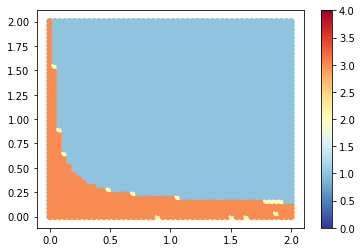

In [ ]:
#### I_0 = 0.2 gEE=0.5
# seach gEI and gIE

param_study = ['g_EE', 'g_IE', 'g_EI']#, 'I_0']
num_param = 2
num_trials = 50


#gEE_rng = np.linspace(0.2,1, 20)
gIE_rng = np.linspace(0.0,2, num_trials)
gEI_rng = np.linspace(0.0,2, num_trials)
fig = plt.figure()
ax = fig.add_subplot(111)#, projection='3d')

gIE, gEI = np.meshgrid(gIE_rng, gEI_rng)#, I0_rng)
#gIE, gEI = np.meshgrid(gIE_rng, gEI_rng)#, I0_rng)
gEE_good =[]
gIE_good =[]
gEI_good =[]
#I0_good =[]
c =[]
eig_v=[]


param['I_0'] = 0.2
param['g_EE'] = 0.5


for i in range(num_trials**num_param):
    ind_0 = i//num_trials**(num_param -1)
    ind_1 = (i%num_trials**(num_param -1)) //num_trials**(num_param -2)
    #ind_2 = ((i%num_trials**(num_param -1)) % num_trials**(num_param -2)) // num_trials**(num_param -3)
    #ind_3 = ((i%num_trials**(num_param -1)) % num_trials**(num_param -2)) % num_trials**(num_param -3)
    #param['g_EE'] = gEE
    param['g_IE'] = gIE[ind_0][ind_1]#[ind_2]#[ind_3]
    param['g_EI'] = gEI[ind_0][ind_1]#[ind_2]#[ind_3]
    #param['I_0'] = I0[ind_0][ind_1][ind_2][ind_3]
    #param['g_EE'] = gEE[ind_0][ind_1][ind_2]#[ind_3]
    """param['g_IE'] = gIE[ind_0][ind_1]#[ind_2]#[ind_3]
    param['g_EI'] = gEI[ind_0][ind_1]#[ind_2]#[ind_3]"""

    """gEE_good.append(param['g_EE'])"""
    gIE_good.append(param['g_IE'])
    gEI_good.append(param['g_EI'])
    #print(param['g_EE'], param['g_IE'], param['g_EI'], param['I_0'])
    initial = np.random.uniform(0.,2, [2, 200])
    solns = []
    for i in range(initial.shape[1]):
        x0 = initial[:,i]
        #print('x0', x0)
        for j in range(20):
            x0 = np.round(fsolve(derivative, x0), decimals =4)

        #print('solutions', solutions)
        #print(derivative(solutions))
        if (np.abs(derivative(x0)) > 1.0).sum() == 0:
            solns.append(tuple(x0))
    #print(len(set(solns)))
    good_sols =[]
    for sol in set(solns):
        sol_good = True
        if len(good_sols)>0:
            for g_sol in good_sols:
                if np.sqrt(((np.array(g_sol)-np.array(sol))**2).mean()) < 1e-3:
                    sol_good = False
                    break
        if sol_good == True:
            good_sols.append(sol)

    #print(len(good_sols))
    c.append(len(good_sols))
    eig_ins=[]
    for sol in good_sols:
        #print(sol, derivative(np.array(sol)))
        eig = get_eig_sys(sol[0], sol[1], param)
        eig_ins.append(eig)
    eig_v.append(eig_ins)
im = ax.scatter(np.array(gIE_good), np.array(gEI_good), cmap ='RdYlBu_r', c = np.array(c), vmax=4, vmin=0) 
fig.colorbar(im, ax = ax)
plt.show()   

/opt/Python-3.5.2/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  
/opt/Python-3.5.2/lib/python3.5/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/opt/Python-3.5.2/lib/python3.5/site-packages/scipy/optimize/minpack.py:163: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


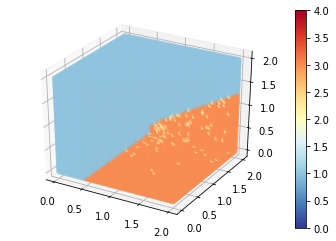

In [ ]:
# fix I0 = 0.2

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

gEE, gIE, gEI = np.meshgrid(gEE_rng, gIE_rng, gEI_rng)#, I0_rng)
#gIE, gEI = np.meshgrid(gIE_rng, gEI_rng)#, I0_rng)
gEE_good =[]
gIE_good =[]
gEI_good =[]
I0_good =[]
c =[]

for i in range(num_trials**num_param):
    ind_0 = i//num_trials**(num_param -1)
    ind_1 = (i%num_trials**(num_param -1)) //num_trials**(num_param -2)
    ind_2 = ((i%num_trials**(num_param -1)) % num_trials**(num_param -2)) // num_trials**(num_param -3)
    #ind_3 = ((i%num_trials**(num_param -1)) % num_trials**(num_param -2)) % num_trials**(num_param -3)
    param['g_EE'] = gEE[ind_0][ind_1][ind_2]#[ind_3]
    param['g_IE'] = gIE[ind_0][ind_1][ind_2]#[ind_3]
    param['g_EI'] = gEI[ind_0][ind_1][ind_2]#[ind_3]
    #param['I_0'] = I0[ind_0][ind_1][ind_2][ind_3]
    #param['g_EE'] = gEE[ind_0][ind_1][ind_2]#[ind_3]
    """param['g_IE'] = gIE[ind_0][ind_1]#[ind_2]#[ind_3]
    param['g_EI'] = gEI[ind_0][ind_1]#[ind_2]#[ind_3]"""
    
    gEE_good.append(param['g_EE'])
    gIE_good.append(param['g_IE'])
    gEI_good.append(param['g_EI'])
    
    #print(param['g_EE'], param['g_IE'], param['g_EI'], param['I_0'])
    initial = np.random.uniform(0.,2, [2, 100])
    solns = []
    for i in range(100):
        x0 = initial[:,i]
        #print('x0', x0)
        for j in range(20):
            x0 = np.round(fsolve(derivative, x0), decimals =4)
        
        #print('solutions', solutions)
        #print(derivative(solutions))
        if (np.abs(derivative(x0)) > 1.0).sum() == 0:
            solns.append(tuple(x0))
    #print(len(set(solns)))
    good_sols =[]
    for sol in set(solns):
        sol_good = True
        if len(good_sols)>0:
            for g_sol in good_sols:
                if np.sqrt(((np.array(g_sol)-np.array(sol))**2).mean()) < 1e-3:
                    sol_good = False
                    break
        if sol_good == True:
            good_sols.append(sol)
            
    #print(len(good_sols))
    c.append(len(good_sols))
    """for sol in good_sols:
        #print(sol, derivative(np.array(sol)))
        eig = get_eig_sys(sol[0], sol[1], param)
        print(sol[0], sol[1], 'eig=', eig)"""

im = ax.scatter(np.array(gEE_good), np.array(gIE_good), np.array(gEI_good), cmap ='RdYlBu_r', c = np.array(c), vmax=4, vmin=0) 
fig.colorbar(im, ax = ax)
plt.show()

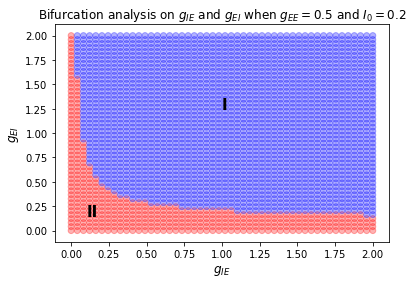

In [ ]:
# Figures for the paper
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
im = ax.scatter(np.array(gIE_good), np.array(gEI_good), cmap ='bwr', c = np.array(c), vmax =2, vmin=1, alpha=0.3) 
ax.set_xlabel('$g_{IE}$', fontsize=12)
ax.set_ylabel('$g_{EI}$', fontsize=12)
ax.text(1,1.25, 'I', fontsize=15, weight='bold')
ax.text(.1,.15, 'II', fontsize=15, weight='bold')
#fig.colorbar(im, ax = ax)
ax.set_title("Bifurcation analysis on $g_{IE}$ and $g_{EI}$ when $g_{EE} = 0.5$ and $I_0=0.2$")home/jw
fig.savefig('/home/jwang/bifurcationanalysis_gEI_gIE.png')
plt.show()

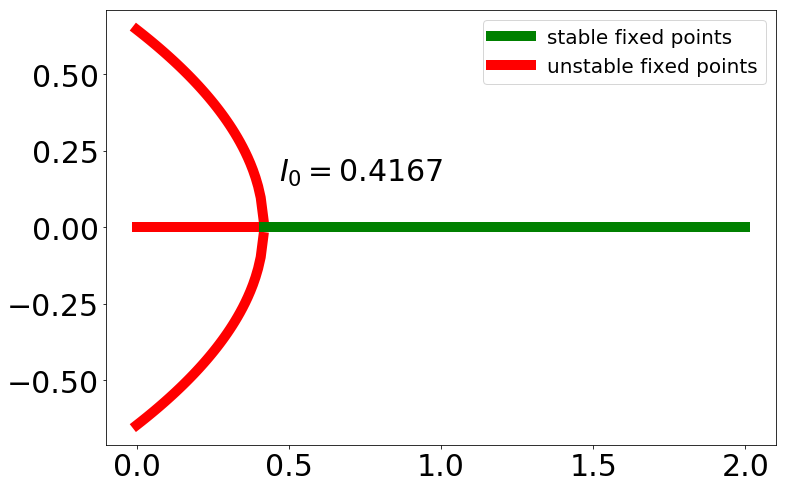

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
I0= 0.4167
x1=np.linspace(0,I0- 0.001,50)
x2 =np.linspace(I0,2)
legend_text =['stable fixed points', 'unstable fixed points']
y1 = np.sqrt(-x1+I0)
y2= - np.sqrt(-x1+I0)
ax.plot(x1, y1, 'r', linewidth=10)
ax.plot(x1, y2, 'r', linewidth=10)
h1, = ax.plot(x1, np.zeros_like(x1), 'r', linewidth=10)
h2, = ax.plot(x2,np.zeros_like(x2), 'g', linewidth=10)
ax.text(I0+0.05, 0.15, '$I_0=$'+str(I0), fontsize = 30)
ax.tick_params(labelsize = 30)
ax.legend([h2,h1], legend_text, fontsize = 20)
plt.show()

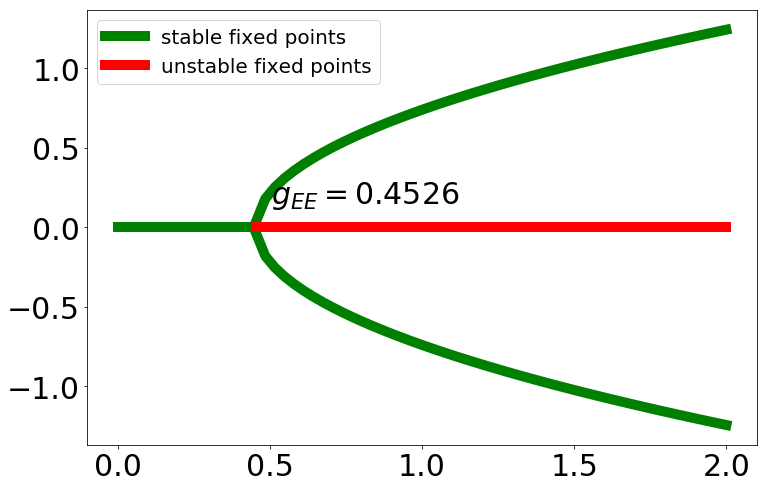

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
gEE= 0.4526
x1=np.linspace(0,gEE,50)
x2 =np.linspace(gEE+0.001,2)
legend_text =['stable fixed points', 'unstable fixed points']
y1 = np.sqrt(x2-gEE)
y2= - np.sqrt(x2-gEE)
ax.plot(x2, y1, 'g', linewidth=10)
ax.plot(x2, y2, 'g', linewidth=10)
h1, = ax.plot(x1, np.zeros_like(x1), 'g', linewidth=10)
h2, = ax.plot(x2,np.zeros_like(x2), 'r', linewidth=10)
ax.text(gEE+0.05, 0.15, '$g_{EE}=$'+str(gEE), fontsize = 30)
ax.tick_params(labelsize = 30)
ax.legend([h1,h2], legend_text, fontsize = 20)
plt.show()